# Boston Housing Prices

In this chapter, we’ll attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on. The dataset we’ll use has relatively few data points: only 506, split between 404 training samples and 102 test samples. Also, each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between, others take values between 1 and 12, others between 0 and 100, and so on.

## Reading-In the Data

The Boston Housing data set is built into Keras.

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

2023-11-07 14:22:12.649785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 14:22:12.688270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 14:22:12.688298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 14:22:12.688330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 14:22:12.695200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 14:22:12.695469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Let's look at the data.

In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

The targets are the median values of owner-occupied homes, in thousands of dollars.  Note that these prices are from the mid-1970s and have not been adjusted for inflation.

In [ ]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## Data Wrangling

It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
for dealing with such data is to do feature-wise normalization: for each feature in the
input data (a column in the input data matrix), we subtract the mean of the feature
and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. This is easily done in **numpy**.

Note that the quantities used for normalizing the `test_data` are computed using the
`train_data`. You should never use any quantity computed on the test data in your
workflow, even for something as simple as data normalization.

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

## Building the Model

We’ll use a small model with two intermediate layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small model is one way to mitigate overfitting.  Since we'll need to instantiate the same model multiple times, we'll use a function to construct it.  This is a common coding pattern you will see in deep learning models.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

The model ends with a single unit and no activation (it will be a linear layer). This is a
typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a `sigmoid` activation function to the last layer,
the model could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the model is free to learn to predict values in any range.

Note that we compile the model with the `mse` loss function — mean squared error, the
square of the difference between the predictions and the targets. This is a widely used
loss function for regression problems.

We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets. For instance, an
MAE of 0.5 on this problem would mean your predictions are off by $500 on average

## Using K-Fold Cross-Validation

We will use k-fold cross-validation to evaluate our model as we adjusts various fitting parameters.  Notice we are doing the cross-validation by hand since we don't have a `cross_validate` function like we do in **sklearn**.

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    
    # preparing the the data from the kth partition
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # building and fitting the model
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    
    # evaluating the model and storing the mae score
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
all_scores

[1.8698797225952148, 2.4602911472320557, 2.446345567703247, 2.5106492042541504]

In [ ]:
np.mean(all_scores)

2.321791410446167

Let’s try training the model a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we’ll modify the training loop to save the per-epoch validation score log for each fold.

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


We can then compute the average of the per-epoch MAE scores for all folds.

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

## Plotting the Validation Scores

Let's plot the the k-fold MAE scores for all the epochs.

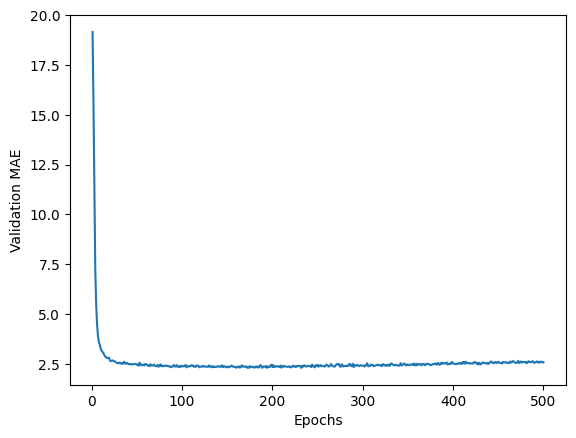

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE
for the first few epochs is dramatically higher than the values that follow. Let’s omit
the first 10 data points, which are on a different scale than the rest of the curve.

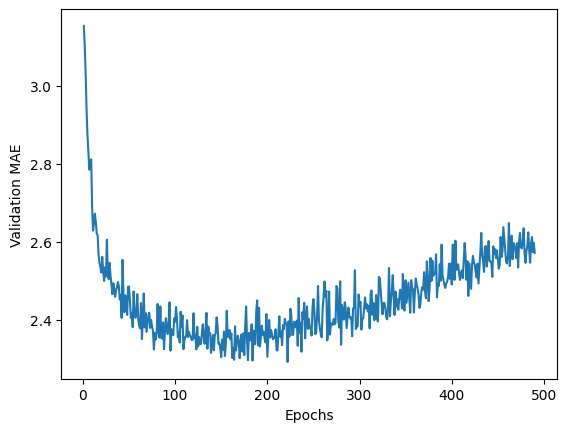

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

As you can see validation MAE stops improving significantly after 120–140 epochs (this number includes the 10 epochs we omitted). Past that point,we start overfitting.

## Training the Final Model

Once you’re finished tuning other parameters of the model (in addition to the
number of epochs, you could also adjust the size of the intermediate layers), you can
train a final production model on all of the training data, with the best parameters,
and then look at its performance on the test data.

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 15.9311 - mae: 2.5011


Here's the final result.  Performance doesn't seem to improve.

In [ ]:
test_mae_score

2.5011422634124756

## Generating Predictions on New Data

With this scalar regression model, predict() returns the model’s guess for the sample’s price in
thousands of dollars:

In [ ]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 1ms/step


array([8.320552], dtype=float32)